In [1]:
%matplotlib inline

import cv2
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import rotate
import PIL
import matplotlib.pyplot as plt
import math
from scipy.fft import fft, fftfreq, fftshift
from libmtf import read_image, Point, ROI, get_roi, get_hamming, get_deriv1, get_centroid, get_polyfit, get_fir2fix, project2

In [2]:
lpdg = 6.25
lpdg = 12.5

In [3]:
def plot_images(image_left, image_right):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    axes[0].imshow(image_left, "gray")
    axes[0].set_title("hori line")
    
    axes[1].imshow(image_right, "gray")
    axes[1].set_title("vert line")
    
def step0_load_image(filename):
    image = read_image(filename)
    return image

def step1_get_roimage(image, topleft, bottomright, rotation):
    roi_image, roi = get_roi(image, topleft, bottomright)
    roi_image = rotate(roi_image, rotation)
    return roi_image, roi

def get_derivative(roi_image):
    deriv = roi_image
    return roi_image

def plot_curves(curve_l, title_l, curve_r, title_r):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    axes[0].plot(curve_l)
    axes[0].set_title(title_l)
    
    axes[1].plot(curve_r)
    axes[1].set_title(title_r)
    
def plot_derivatives(deriv_l, deriv_r):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    for i in range(deriv_l.shape[0]):
        axes[0].plot(deriv_l[i, :])
    axes[0].set_title("hori line: LSF for all rows")
    
    for i in range(deriv_l.shape[0]):
        axes[1].plot(deriv_r[i, :])
    axes[1].set_title("vert line: LSF for all rows")

def get_fit(curve):
    x = np.arange(len(curve))
    y = curve
    fit = get_polyfit(x, y, 1)
    return fit
    
def step4_get_centroid_and_fit(deriv, hamming_win):
    centroid = get_centroid(deriv * hamming_win) - 0.5
    fit = get_fit(centroid)
    return centroid, fit

def plot_centroid(image_l, centroid_l, fit_l, image_r, centroid_r, fit_r):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    axes[0].imshow(image_l, "gray")
    axes[0].set_title("hori line")
    axes[0].plot(centroid_l, np.arange(len(centroid_l)), 'r')
    x = np.arange(len(centroid_l))
    y = centroid_l
    axes[0].plot(np.polyval(fit_l, x), x, "y")
    
    axes[1].imshow(image_r, "gray")
    axes[1].set_title("vert line")
    axes[1].plot(centroid_r, np.arange(len(centroid_r)), 'r')
    x = np.arange(len(centroid_r))
    y = centroid_r
    axes[1].plot(np.polyval(fit_r, x), x, "y")
    

def plot_lsf(lsf_curve, centroid, fit, roi_image_limited):
    plt.subplot(1, 2, 1)
    plt.title("LSF after Hamming window")
    plt.imshow(lsf_curve)
    plt.plot(centroid, np.arange(len(centroid)), 'r')

    x = np.arange(len(centroid))
    y = centroid
    plt.plot(np.polyval(fit, x), x, "y")

    plt.subplot(1, 2, 2)
    plt.title("LSF limted")
    plt.imshow(roi_image_limited)

def step5_fit_central(fit, centroid, deriv_v, win1_v):
    centroid_place = np.polyval(fit, np.arange(len(centroid)))
    hamming_width = deriv_v.shape[1]

    win2 = [get_hamming(hamming_width, centroid_place[i]) for i in range(len(centroid_place))]
    win2 = np.array(win2)
    deriv_hamming_windowed = deriv_v*win2

    centroid, fit = step4_get_centroid_and_fit(deriv_hamming_windowed, win1_v)

    slout_ = -fit[0]
    slout = 180*math.atan(slout_)/math.pi

    # Evaluate equation at the middle line as edge location
    midloc = np.polyval(fit, deriv_v.shape[0]/2)

    # Limit number of lines to integer (npix*line slope as per ISO 12233
    nlin = deriv_v.shape[0]
    a = math.floor(nlin*abs(slout))
    b = abs(slout)
    nlin1 = round(a/b)

    roi_image_limited = deriv_hamming_windowed[:nlin1, :]

    # plot_lsf(deriv_hamming_windowed, centroid, fit, roi_image_limited)

    vslope = -fit[0]
    slope_deg = slout
    delimage = 1

    # correct sampling interval for sampling normal to edge
    delfac = math.cos(math.atan(vslope))

    # input pixel sampling normal to edge
    del1n = delfac
    nbin = 4
    # super-sampling interval normal to edge
    del2 = del1n/nbin

    nn = math.ceil(deriv_hamming_windowed.shape[1]*nbin)
    nn2 = math.floor(nn/2) + 1

    # dcorr corrects SFR for response of FIR filter
    dcorr = get_fir2fix(nn2, 3)

    freqlim = 1
    if nbin == 1:
        freqlim = 2
        
    nn2out = round(nn2*freqlim/2)

    # half-sampling frequency
    nfreq = nn/(2*delimage*nn)    

    return roi_image_limited, nbin, nn2, del2

def step6_super_sample(roi_image_limited, fit, nbin):
    esf = project2(roi_image_limited, fit, nbin)
    l = len(esf)
    esf[l-1] = esf[l-2]
    return esf

def step7_get_lsf(esf):
    lsf1 = esf
    return lsf1

def step8_apply_win_to_lsf(lsf1_v):
    nn = len(lsf1_v)
    mm = np.argmax(lsf1_v)

    win3_v = get_hamming(nn, mm)
    win3_v = np.array(win3_v)
    lsf1_v = np.array(lsf1_v)
    lsf_v = lsf1_v * win3_v

    return lsf_v, win3_v

def step9_get_mtf(lsf, nn2, del2):
    temp = abs(fft(lsf))
    mtf = temp[0:nn2] / temp[0]
    # Compute frequency values

    # print("del2", del2, "nn", nn)
    nn = len(lsf)
    freq = [i / (del2*nn) for i in range(nn)]
    freq = np.array(freq)
    mtf = np.array(mtf)

    nn_2_out = 70
    nn2out=nn_2_out # for smartmtf
    efl = 60
    px = 3.45
    px=2.74

    lppd = px/efl/1000 * 180/3.14159

    freq_data = freq[0:nn2out]/lppd
    mtf_data = mtf[0:nn2out]

    return freq_data, mtf_data

def step10_get_mtf_interp(mtf_array, freq_array, frequency):
    for idx, freq in enumerate(freq_array):
        # print(idx, freq)
        if frequency < freq:
            break

    mtf = (frequency-freq_array[idx-1])/(freq_array[idx]-freq_array[idx-1])*(mtf_array[idx]-mtf_array[idx-1]) + mtf_array[idx-1]
    return frequency, mtf
    
def plot_mtf(freq_data, mtf_data, label, linestyle):
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.plot(freq_data, mtf_data, label=label, linestyle=linestyle)
    plt.legend()

In [4]:
def thru_focus(index, freq, files, w, h, debug=False):
    # step 0: load image
    file_item = files[index]
    image = step0_load_image(file_item["filename"])
    title = file_item["title"]
    
    # step 1: get ROI
    roi_image_h, roi = step1_get_roimage(image, file_item["roi_h_pos"], (file_item["roi_h_pos"][0] + w, file_item["roi_h_pos"][1] + h), 90) #90
    roi_image_v, roi = step1_get_roimage(image, file_item["roi_v_pos"], (file_item["roi_v_pos"][0] + h, file_item["roi_v_pos"][1] + w), 0)
    if debug:
        plot_images(roi_image_h, roi_image_v)
    
    # step 2: hamming window
    win1_h = get_hamming(roi_image_h.shape[1])
    win1_v = get_hamming(roi_image_v.shape[1])
    
    # step 3: get derivative
    deriv_h = get_derivative(roi_image_h)
    deriv_v = get_derivative(roi_image_v)
    if debug:
        plot_derivatives(deriv_h, deriv_v)
    
    # step 4: apply window and compute centroid
    centroid_h, fit_h = step4_get_centroid_and_fit(deriv_h, win1_h)
    centroid_v, fit_v = step4_get_centroid_and_fit(deriv_v, win1_v)
    if debug:
        plot_centroid(deriv_h, centroid_h, fit_h, deriv_v, centroid_v, fit_v)
    
    # step 5: compute polynomial fit to central locations
    
    roi_image_limited_h, nbin_h, nn2_h, del2_h = step5_fit_central(fit_h, centroid_h, deriv_h, win1_h)
    roi_image_limited_v, nbin_v, nn2_v, del2_v = step5_fit_central(fit_v, centroid_v, deriv_v, win1_v)
    if debug:
        print("roi_image_limited_h:", roi_image_limited_h.shape)
        print("roi_image_limited_v:", roi_image_limited_v.shape)
        print("nbin_h:", nbin_h)
        print("nbin_v:", nbin_v)
        print("nn2_h:", nn2_h)
        print("nn2_v:", nn2_v)
        print("del2_h:", del2_h)
        print("del2_v:", del2_v)
        plot_images(roi_image_limited_h, roi_image_limited_v)
        
    # step 6: super-sample
    esf_h = step6_super_sample(roi_image_limited_h, fit_h, nbin_h)
    esf_v = step6_super_sample(roi_image_limited_v, fit_v, nbin_v)
    if debug:
        plot_curves(esf_h, "esf_h", esf_v, "esf_v")
    
     # step 7: compute 1D derivative (LSF)
    
    lsf1_h = step7_get_lsf(esf_h)
    lsf1_v = step7_get_lsf(esf_v)
    if debug:
        plot_curves(lsf1_h, "lsf_h", lsf1_v, "lsf_v")
    
    # step 8: apply window to LSF
    
    lsf_h, win3_h = step8_apply_win_to_lsf(lsf1_h)
    lsf_v, win3_v = step8_apply_win_to_lsf(lsf1_v)
    # plt.subplot(1, 2, 1)
    # plt.title("without hamming")
    # plt.plot(lsf_h)
    
    # plt.subplot(1, 2, 2)
    # plt.title("hamming")
    # plt.plot(lsf1_h * win3_h)
    # plt.plot(win3_h*200) 
    
    # step 9: MTF
    freq_data_h, mtf_data_h = step9_get_mtf(lsf_h, nn2_h, del2_h)
    freq_data_v, mtf_data_v = step9_get_mtf(lsf_v, nn2_v, del2_v)
    # plot_mtf(freq_data_h, mtf_data_h, "h", "-")
    # plot_mtf(freq_data_v, mtf_data_v, "v", "--")
    
    freq, mtf_h = step10_get_mtf_interp(mtf_data_h, freq_data_h, freq)
    freq, mtf_v = step10_get_mtf_interp(mtf_data_v, freq_data_v, freq)

    result = {
        "title": title,
        "freq": freq,
        "mtf_h": float(mtf_h),
        "mtf_v": float(mtf_v),
        "roi_image_h": roi_image_h,
        "roi_image_v": roi_image_v,
        "lsf_h": lsf_h,
        "lsf_v": lsf_v,
        "freq_data": freq_data_h,
        "mtf_data_h": mtf_data_h,
        "mtf_data_v": mtf_data_v
    }
    return result

def do_thru_focus(scan_files):
    t_focus_d = []
    t_focus_h = []
    t_focus_v = []
    
    freq_numbers = 40
    freqency = lpdg
    
    for idx in range(len(scan_files)):
        res = thru_focus(idx, freqency, scan_files, 100, 100, False)
        # print(res["title"][0:-2], res["mtf_h"], res["mtf_v"])
        t_focus_d.append(float(res["title"][0:-2]))
        t_focus_h.append(res["mtf_h"])
        t_focus_v.append(res["mtf_v"])
    return t_focus_d, t_focus_h, t_focus_v

In [5]:
# display ROIs
def display_roi(scan_files, idx, w, h):
    freq_numbers = 20
    freqency = lpdg
    # idx = 10
    
    res = thru_focus(idx, freqency, scan_files, w, h, False)
    # print(res["title"][0:-2], res["mtf_h"], res["mtf_v"])
    # t_focus_d.append(float(res["title"][0:-2]))
    # t_focus_h.append(res["mtf_h"])
    # t_focus_v.append(res["mtf_v"])
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(res["roi_image_h"], "gray")
    axes[0].set_title("hori line")
    
    axes[1].imshow(res["roi_image_v"], "gray")
    axes[1].set_title("vert line")
    
    # print(res["freq_data"][0:freq_numbers])
    # print(res["mtf_data_h"][0:freq_numbers])
    # print(res["mtf_data_v"][0:freq_numbers])
    
    axes[2].plot(res["freq_data"][0:freq_numbers], res["mtf_data_h"][0:freq_numbers], label='MTF in H line', linestyle='-')
    axes[2].plot(res["freq_data"][0:freq_numbers], res["mtf_data_v"][0:freq_numbers], label='MTF in V line', linestyle='-')
    axes[2].set_title(f"motor position: {res['title']}")
    axes[2].set_xlabel("lp/deg")
    axes[2].grid(color='gray', linestyle='--', linewidth=1)
    axes[2].legend()

def plot_thrufocus(t_focus_d, t_focus_h, t_focus_v, title):
    plt.grid(color="gray", linestyle="--", linewidth=1)
    plt.plot(t_focus_d, np.array(t_focus_h), label="h line", linestyle="-")
    plt.plot(t_focus_d, np.array(t_focus_v), label="v line", linestyle="--")
    plt.xlabel("motor position")
    plt.ylabel("MTF")
    plt.title(title)
    plt.legend()

def adjust_thrufocus(t_focus_d, t_focus_h, t_focus_v, kh, kv, shift=0):
    ah = np.array(t_focus_h)*kh
    av = np.array(t_focus_v)*kv
    ad = np.array(t_focus_d)
    if shift > 0:
        ad = ad[shift:]
        ah = ah[shift:]
        av = av[:-shift]
    elif shift < 0:
        ad = ad[:shift]
        ah = ah[:shift]
        av = av[-shift:]

    return ad, ah, av

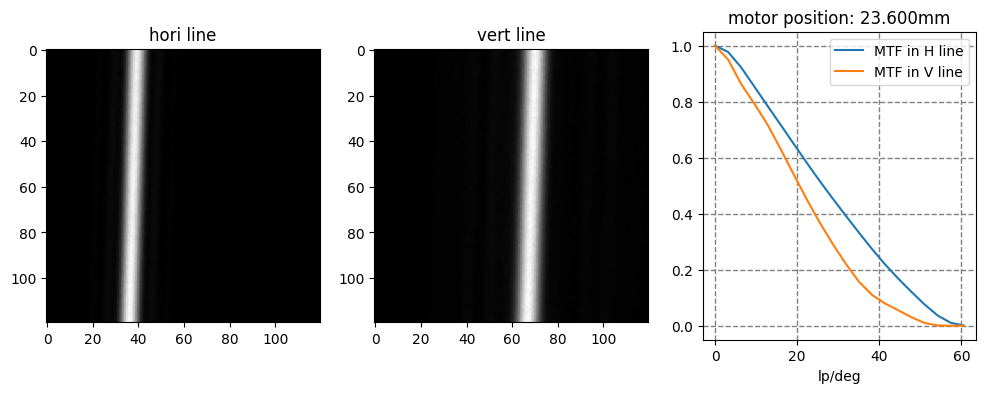

In [60]:
# RED light source

red_light = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/1202/red/red_{idx/1000:.3f}.png",
    "roi_h_pos": (1780, 817),
    "roi_v_pos": (1650, 964),
} for idx in range(22550, 24500, 50)]
nn = 21

display_roi(red_light, nn, 120, 120)

In [61]:
t_focus_d_red, t_focus_h_red, t_focus_v_red = do_thru_focus(red_light)

In [62]:
ad, ah, av = adjust_thrufocus(t_focus_d_red, t_focus_h_red, t_focus_v_red, kh=1.00, kv = 1.00, shift=3)
x = (np.arange(ah.shape[0]))
zh = np.polyfit(x, ah, 2)
ph = np.poly1d(zh)
afh = ph(x)
zv = np.polyfit(x, av, 2)
pv = np.poly1d(zv)
afv = pv(x)
print(ah.argmax(), ah)
print(av.argmax(), av)

29 [0.65962843 0.67123754 0.68269384 0.69237694 0.7030085  0.71311518
 0.72212724 0.73160109 0.74051914 0.74850017 0.75575537 0.76369417
 0.76955041 0.77511958 0.78102658 0.78602555 0.79036874 0.7949282
 0.79791141 0.80078328 0.80354956 0.80494966 0.80565263 0.80679878
 0.80735855 0.80820401 0.81018909 0.81291024 0.81672301 0.82048578
 0.81773621 0.8135641  0.81098701 0.81009429 0.80835761 0.8061961 ]
35 [0.58532139 0.59358277 0.60263921 0.61169657 0.62000969 0.62771686
 0.63562612 0.64374202 0.65093633 0.65866934 0.66651203 0.67350167
 0.67968657 0.68611044 0.69181405 0.69700024 0.7025472  0.70772897
 0.71224539 0.71688513 0.72067509 0.72484408 0.72893985 0.7322409
 0.73555389 0.73817106 0.74051287 0.74401892 0.7458571  0.74650687
 0.74857643 0.75054845 0.75458029 0.75642119 0.75783287 0.75959887]


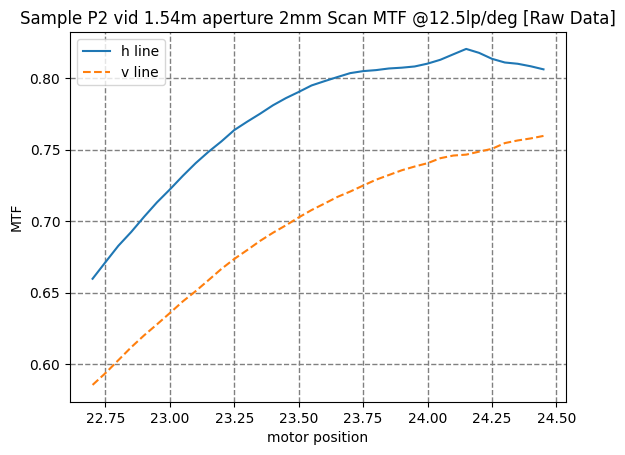

In [63]:
plot_thrufocus(ad, ah, av, title=f"Sample P2 vid 1.54m aperture 2mm Scan MTF @{lpdg}lp/deg [Raw Data]")

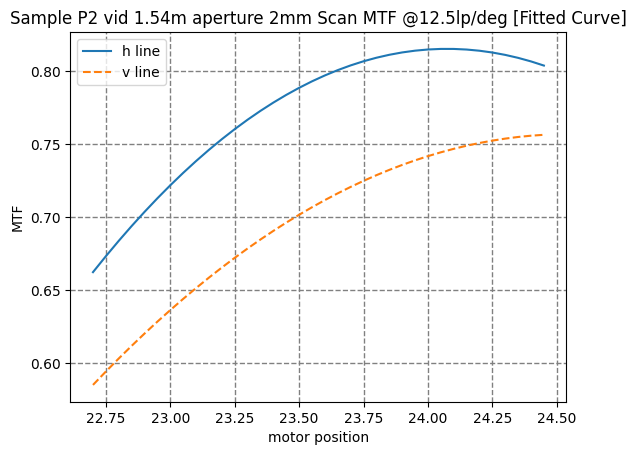

In [64]:
plot_thrufocus(ad, afh, afv, title=f"Sample P2 vid 1.54m aperture 2mm Scan MTF @{lpdg}lp/deg [Fitted Curve]")

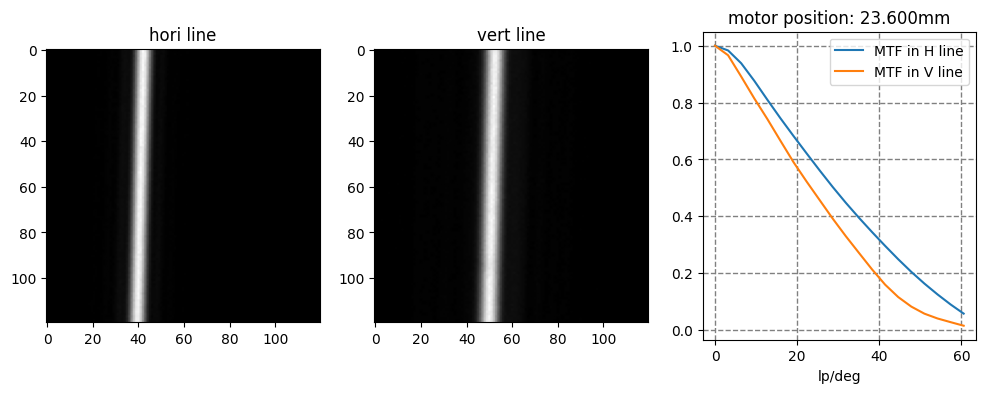

In [120]:
# GRN light source
grn_light = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/1202/grn/grn_{idx/1000:.3f}.png",
    "roi_h_pos": (1194, 952),
    "roi_v_pos": (986, 1140),
} for idx in range(22550, 24500, 50)]
nn =21

display_roi(grn_light, nn, 120, 120)

In [73]:
t_focus_d_grn, t_focus_h_grn, t_focus_v_grn = do_thru_focus(grn_light)

In [76]:
ad, ah, av = adjust_thrufocus(t_focus_d_grn, t_focus_h_grn, t_focus_v_grn, kh=1.00, kv = 1.00, shift=0)
x = (np.arange(ah.shape[0]))
zh = np.polyfit(x, ah, 2)
ph = np.poly1d(zh)
afh = ph(x)
zv = np.polyfit(x, av, 2)
pv = np.poly1d(zv)
afv = pv(x)
print(ah.argmax(), ah)
print(av.argmax(), av)

32 [0.64865088 0.66078346 0.67343595 0.68524954 0.69624166 0.70751692
 0.71783933 0.72838927 0.7380285  0.74648909 0.75617602 0.76481121
 0.77268105 0.78008591 0.7872127  0.79313547 0.79911463 0.8038801
 0.80950393 0.81374622 0.8185229  0.82054249 0.8240225  0.82606287
 0.82779192 0.82933915 0.8292508  0.83007427 0.83079542 0.83321902
 0.83576205 0.83884114 0.83904293 0.83763598 0.83617539 0.83437046
 0.83164601 0.82960036 0.82882249]
8 [0.77982164 0.78210371 0.78361729 0.7863576  0.78710388 0.78880247
 0.78965361 0.78970738 0.78989456 0.7898913  0.78975675 0.78874877
 0.78783625 0.78635139 0.78516986 0.78289223 0.77964709 0.77664741
 0.77340584 0.76989019 0.7648888  0.76081099 0.75610112 0.75223638
 0.74793016 0.74247819 0.73580284 0.73254123 0.72444866 0.71829157
 0.71443318 0.71350407 0.71097316 0.71102518 0.71115299 0.71065912
 0.71119151 0.71196158 0.71101152]


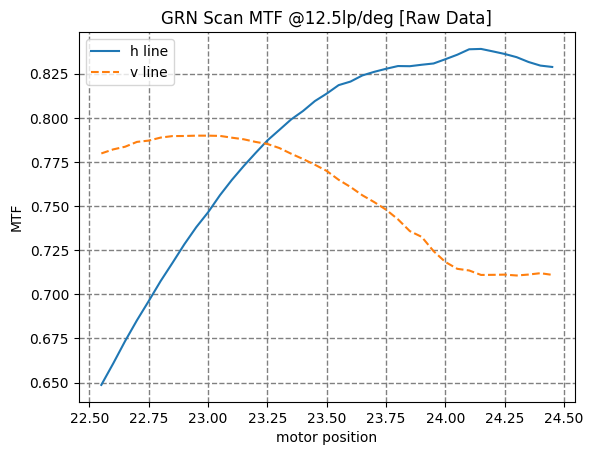

In [77]:
plot_thrufocus(ad, ah, av, title=f"GRN Scan MTF @{lpdg}lp/deg [Raw Data]")

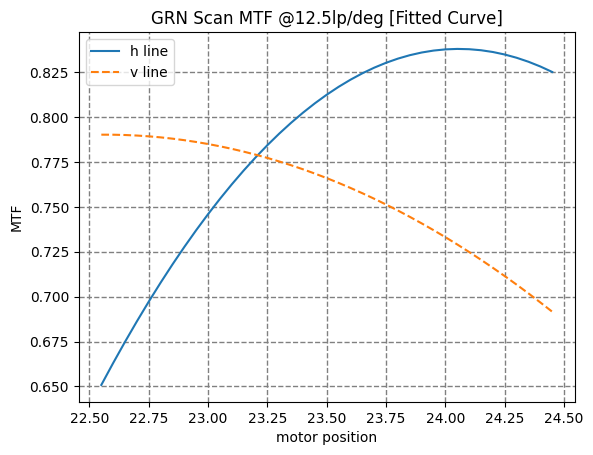

In [78]:
plot_thrufocus(ad, afh, afv, title=f"GRN Scan MTF @{lpdg}lp/deg [Fitted Curve]")

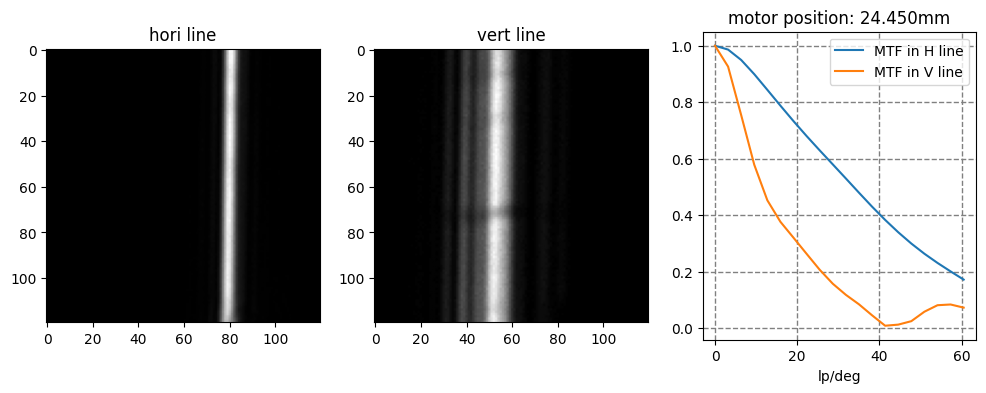

In [121]:
# BLU light source
blu_light = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/1202/blu/blu_{idx/1000:.3f}.png",
    "roi_h_pos": (1603, 759),
    "roi_v_pos": (1407, 612),
} for idx in range(22550, 24500, 50)]
nn=38
display_roi(blu_light, nn, 120, 120)

In [122]:
t_focus_d_blu, t_focus_h_blu, t_focus_v_blu = do_thru_focus(blu_light)

In [123]:
ad, ah, av = adjust_thrufocus(t_focus_d_blu, t_focus_h_blu, t_focus_v_blu, kh=1.00, kv = 1.00, shift=0)
x = (np.arange(ah.shape[0]))
zh = np.polyfit(x, ah, 2)
ph = np.poly1d(zh)
afh = ph(x)
zv = np.polyfit(x, av, 2)
pv = np.poly1d(zv)
afv = pv(x)
print(ah.argmax(), ah)
print(av.argmax(), av)

32 [0.64716021 0.66145388 0.67700931 0.69075044 0.70379587 0.71608695
 0.72882489 0.7404775  0.75219676 0.76299697 0.77374778 0.78416944
 0.79295946 0.8014772  0.8106784  0.81760228 0.82469109 0.83131283
 0.83665215 0.8419219  0.84674238 0.85081811 0.85548334 0.85675686
 0.85892902 0.8598542  0.86092856 0.86132784 0.86122652 0.86542329
 0.87307334 0.87819173 0.87856814 0.87298626 0.86488775 0.85920673
 0.85531282 0.85238298 0.84796724]
26 [0.43119097 0.43922848 0.43759969 0.44215839 0.44333575 0.44566979
 0.45389413 0.45641299 0.45685417 0.46241331 0.46244746 0.4660038
 0.46925301 0.47028294 0.47584176 0.4791033  0.48268827 0.48995623
 0.4916391  0.49577014 0.50263387 0.50385601 0.50960697 0.51358112
 0.51647652 0.52178188 0.52508246 0.5199355  0.51507824 0.51486315
 0.51494692 0.51169829 0.50703129 0.50309349 0.49839562 0.49858273
 0.49737394 0.49463715 0.49303021]


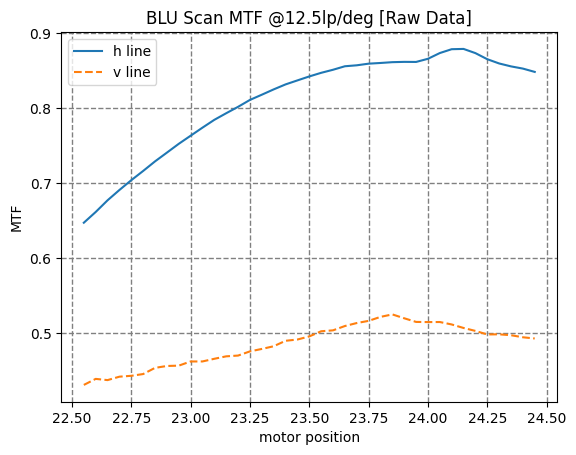

In [124]:
plot_thrufocus(ad, ah, av, title=f"BLU Scan MTF @{lpdg}lp/deg [Raw Data]")

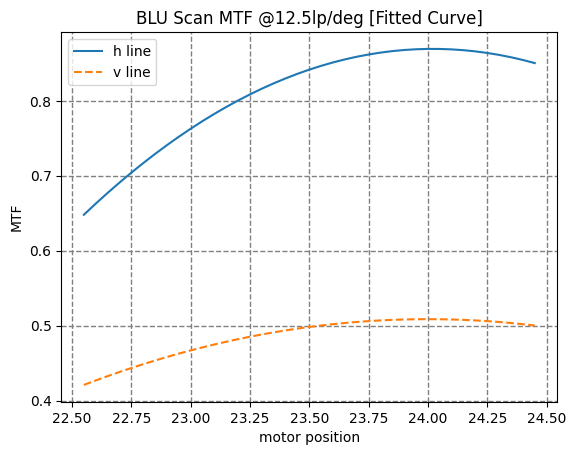

In [125]:
plot_thrufocus(ad, afh, afv, title=f"BLU Scan MTF @{lpdg}lp/deg [Fitted Curve]")